# scratch

In [ ]:
import numpy as np
import math
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Simple 2-layer neural network
        input_size: number of input features
        hidden_size: number of neurons in hidden layer
        output_size: number of output neurons (1 for binary classification)
        """
        self.learning_rate = learning_rate

        # Initialize weights randomly (small values)
        # Weights from input to hidden layer
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros((1, hidden_size))

        # Weights from hidden to output layer
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros((1, output_size))

    def sigmoid(self, x):
        """Sigmoid activation function"""
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)

    def forward(self, X):
        """Forward propagation"""
        # Input to hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        # Hidden to output layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        return self.a2

    def backward(self, X, y, output):
        """Backward propagation (computing gradients)"""
        m = X.shape[0]  # number of examples

        # Calculate error at output layer
        dz2 = output - y
        dW2 = (1/m) * np.dot(self.a1.T, dz2)
        db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)

        # Calculate error at hidden layer
        dz1 = np.dot(dz2, self.W2.T) * self.sigmoid_derivative(self.a1)
        dW1 = (1/m) * np.dot(X.T, dz1)
        db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)

        # Update weights and biases
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

    def train(self, X, y, epochs=1000):
        """Train the neural network"""
        costs = []

        for i in range(epochs):
            # Forward propagation
            output = self.forward(X)

            # Calculate cost (binary cross-entropy)
            cost = self.compute_cost(y, output)
            costs.append(cost)

            # Backward propagation
            self.backward(X, y, output)

            # Print cost every 100 epochs
            if i % 100 == 0:
                print(f"Cost after epoch {i}: {cost:.4f}")

        return costs

    def compute_cost(self, y, output):
        """Compute binary cross-entropy cost"""
        m = y.shape[0]
        # Add small epsilon to prevent log(0)
        epsilon = 1e-15
        output = np.clip(output, epsilon, 1 - epsilon)
        cost = -(1/m) * np.sum(y * np.log(output) + (1 - y) * np.log(1 - output))
        return cost

    def predict(self, X):
        """Make predictions"""
        output = self.forward(X)
        return (output > 0.5).astype(int)

    def accuracy(self, X, y):
        """Calculate accuracy"""
        predictions = self.predict(X)
        return np.mean(predictions == y) * 100

# Load and prepare the Pima Indians Diabetes dataset
def load_data():
    """Load Pima Indians Diabetes dataset"""
    try:
        # Try to load from sklearn
        data = fetch_openml('diabetes', version=1, as_frame=True)
        X = data.data.values
        y = data.target.values

        # Convert target to binary (0 or 1)
        y = (y == 'tested_positive').astype(int).reshape(-1, 1)

    except:
        # If sklearn doesn't work, create sample data
        print("Creating sample data (replace with actual Pima dataset)")
        np.random.seed(42)
        n_samples = 768
        n_features = 8

        X = np.random.randn(n_samples, n_features)
        # Create some correlation for realistic results
        diabetes_score = np.sum(X[:, [1, 5, 7]], axis=1) + np.random.randn(n_samples) * 0.5
        y = (diabetes_score > 0).astype(int).reshape(-1, 1)

    return X, y



In [ ]:
# Main execution
if __name__ == "__main__":
    print("=== Simple Neural Network for Diabetes Prediction ===\n")

    # Load data
    X, y = load_data()
    print(f"Dataset shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Positive cases: {np.sum(y)} ({np.mean(y)*100:.1f}%)\n")

    # Normalize features (important for neural networks)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples\n")

    # Create and train neural network
    nn = SimpleNeuralNetwork(
        input_size=X_train.shape[1],  # 8 features
        hidden_size=10,               # 10 hidden neurons
        output_size=1,                # 1 output (binary classification)
        learning_rate=0.1
    )

    print("Training Neural Network...")
    print("-" * 40)

    # Train the model
    costs = nn.train(X_train, y_train, epochs=1000)

    print("-" * 40)
    print("Training completed!\n")

    # Evaluate the model
    train_accuracy = nn.accuracy(X_train, y_train)
    test_accuracy = nn.accuracy(X_test, y_test)

    print("=== Results ===")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Show some predictions
    print("\n=== Sample Predictions ===")
    sample_predictions = nn.forward(X_test[:5])
    for i in range(5):
        actual = y_test[i][0]
        predicted = sample_predictions[i][0]
        predicted_class = 1 if predicted > 0.5 else 0
        print(f"Sample {i+1}: Actual={actual}, Predicted={predicted:.3f} (Class={predicted_class})")

    print(f"\n=== Network Architecture ===")
    print(f"Input Layer: {X_train.shape[1]} neurons (features)")
    print(f"Hidden Layer: 10 neurons (with sigmoid activation)")
    print(f"Output Layer: 1 neuron (with sigmoid activation)")
    print(f"Total Parameters: {np.sum([w.size for w in [nn.W1, nn.b1, nn.W2, nn.b2]])}")

=== Simple Neural Network for Diabetes Prediction ===

Dataset shape: (768, 8)
Target shape: (768, 1)
Positive cases: 268 (34.9%)

Training set: 614 samples
Test set: 154 samples

Training Neural Network...
----------------------------------------
Cost after epoch 0: 0.7219
Cost after epoch 100: 0.6298
Cost after epoch 200: 0.5964
Cost after epoch 300: 0.5460
Cost after epoch 400: 0.5060
Cost after epoch 500: 0.4847
Cost after epoch 600: 0.4741
Cost after epoch 700: 0.4688
Cost after epoch 800: 0.4659
Cost after epoch 900: 0.4644
----------------------------------------
Training completed!

=== Results ===
Training Accuracy: 77.85%
Test Accuracy: 74.03%

=== Sample Predictions ===
Sample 1: Actual=0, Predicted=0.269 (Class=0)
Sample 2: Actual=0, Predicted=0.144 (Class=0)
Sample 3: Actual=0, Predicted=0.101 (Class=0)
Sample 4: Actual=0, Predicted=0.202 (Class=0)
Sample 5: Actual=0, Predicted=0.510 (Class=1)

=== Network Architecture ===
Input Layer: 8 neurons (features)
Hidden Layer: 10

# huggingface

In [1]:
!pip install transformers torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 767.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [1]:
# DeepSeek HuggingFace Demo
# First run: !pip install transformers torch accelerate
# Then restart runtime: Runtime -> Restart Runtime
# Then run this code

import sys
try:
    from transformers import pipeline
    import torch
except ImportError:
    print("Please install required packages:")
    print("!pip install transformers torch accelerate")
    print("Then restart runtime and run again")
    sys.exit()

# Initialize DeepSeek model
print("Loading DeepSeek model...")
generator = pipeline(
    "text-generation",
    model="deepseek-ai/deepseek-coder-1.3b-instruct",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device=0 if torch.cuda.is_available() else -1,
    trust_remote_code=True
)

# Simple prompt
prompt = "What is ML?"
formatted_prompt = f"User: {prompt}\nAssistant:"

# Generate response
print(f"Prompt: {prompt}")
result = generator(
    formatted_prompt,
    max_length=100,
    temperature=0.7,
    do_sample=True,
    pad_token_id=generator.tokenizer.eos_token_id
)

# Clean and display response
response = result[0]['generated_text'].split("Assistant:")[-1].strip()
print(f"Response: {response}")


Loading DeepSeek model...


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Prompt: What is ML?
Response: Absolutely, here are some basics of Machine Learning:

1. **Data Collection**: Gathering data is the first step in any machine learning process. The data that you collect will depend on the specifics of the problem you are trying to solve. This data can be from databases, websites, sensor data, images, etc.

2. **Data Preprocessing**: Once you have collected your data, you need to clean, normalize, and transform it. This may involve dealing with missing values, outliers, and converting categorical data into numeric data.

3. **Model Selection**: This is the decision-making process. You must choose the right type of machine learning algorithm to use.

4. **Training the Model**: Once you've chosen your algorithm, you need


# gemini

In [3]:
# Gemini API Demo
# pip install google-generativeai

import google.generativeai as genai
from google.colab import userdata

# Configure API key (for Colab)
genai.configure(api_key=userdata.get('GEMINI_API_KEY'))

# Initialize model
model = genai.GenerativeModel('gemini-1.5-flash')

# Simple prompt
prompt = "What is ML?"

# Configure generation parameters
generation_config = genai.types.GenerationConfig(
    max_output_tokens=100,
    temperature=0.7,
    top_p=0.9,
    top_k=40
)

# Generate response
response = model.generate_content(prompt, generation_config=generation_config)
print(f"Prompt: {prompt}")
print(f"Response: {response.text}")

Prompt: What is ML?
Response: ML stands for **Machine Learning**.  It's a branch of artificial intelligence (AI) and computer science which focuses on the use of data and algorithms to imitate the way that humans learn, gradually improving its accuracy.  Instead of being explicitly programmed, machine learning systems learn from data.

In simpler terms, you feed a machine learning system lots of data, and it uses that data to identify patterns, make predictions, and improve its performance over time without being explicitly told how to do so.


In [6]:
# Gemini API Demo
# pip install google-generativeai

import google.generativeai as genai
from google.colab import userdata

# Configure API key (for Colab)
genai.configure(api_key=userdata.get('GEMINI_API_KEY'))

# Initialize model
model = genai.GenerativeModel('gemini-1.5-flash')

# Simple prompt
prompt = "What is a neural network?"

# Configure generation parameters
generation_config = genai.types.GenerationConfig(
    max_output_tokens=100,
    temperature=0.7,
    top_p=0.9,
    top_k=40
)

# Generate response
response = model.generate_content(prompt, generation_config=generation_config)
print(f"Prompt: {prompt}")
print(f"Response: {response.text}")

Prompt: What is a neural network?
Response: A neural network is a computing system inspired by the biological neural networks that constitute animal brains.  It's a complex interconnected system of simple processing units, called **neurons** or **nodes**, organized in layers.  These layers typically include:

* **Input layer:** Receives the initial data (e.g., pixels in an image, words in a sentence).
* **Hidden layers:** Perform computations on the data, extracting features and patterns.  There can be multiple hidden layers, allowing


# pytorch

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

class SimpleNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

def load_data():
    """Load Pima Indians Diabetes dataset"""
    try:
        data = fetch_openml('diabetes', version=1, as_frame=True)
        X = data.data.values.astype(np.float32)
        y = data.target.values
        y = (y == 'tested_positive').astype(np.float32)
    except:
        print("Creating sample data")
        np.random.seed(42)
        n_samples = 768
        n_features = 8
        X = np.random.randn(n_samples, n_features).astype(np.float32)
        diabetes_score = np.sum(X[:, [1, 5, 7]], axis=1) + np.random.randn(n_samples) * 0.5
        y = (diabetes_score > 0).astype(np.float32)

    return X, y

def main():
    print("=== Simple PyTorch Neural Network for Diabetes Prediction ===\n")

    # Load data
    X, y = load_data()
    print(f"Dataset shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Positive cases: {np.sum(y)} ({np.mean(y)*100:.1f}%)\n")

    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples\n")

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1)

    # Create neural network (same architecture as original)
    model = SimpleNeuralNetwork(
        input_size=X_train.shape[1],  # 8 features
        hidden_size=10,               # 10 hidden neurons (same as original)
        output_size=1                 # 1 output
    )

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)  # Same learning rate as original

    print("Training Neural Network...")
    print("-" * 40)

    # Training loop
    costs = []
    epochs = 1000  # Same as original

    for epoch in range(epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        costs.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print cost every 100 epochs (same as original)
        if epoch % 100 == 0:
            print(f"Cost after epoch {epoch}: {loss.item():.4f}")

    print("-" * 40)
    print("Training completed!\n")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_outputs = model(X_train_tensor)
        test_outputs = model(X_test_tensor)

        train_predictions = (train_outputs > 0.5).float()
        test_predictions = (test_outputs > 0.5).float()

        train_accuracy = (train_predictions == y_train_tensor).float().mean() * 100
        test_accuracy = (test_predictions == y_test_tensor).float().mean() * 100

    print("=== Results ===")
    print(f"Training Accuracy: {train_accuracy:.2f}%")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Show some predictions (same as original)
    print("\n=== Sample Predictions ===")
    with torch.no_grad():
        sample_predictions = model(X_test_tensor[:5])
        for i in range(5):
            actual = y_test_tensor[i].item()
            predicted = sample_predictions[i].item()
            predicted_class = 1 if predicted > 0.5 else 0
            print(f"Sample {i+1}: Actual={int(actual)}, Predicted={predicted:.3f} (Class={predicted_class})")

    print(f"\n=== Network Architecture ===")
    print(f"Input Layer: {X_train.shape[1]} neurons (features)")
    print(f"Hidden Layer: 10 neurons (with sigmoid activation)")
    print(f"Output Layer: 1 neuron (with sigmoid activation)")

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params}")

    # Save training history for plotting
    torch.save({
        'costs': costs,
        'model_state': model.state_dict(),
        'train_accuracy': train_accuracy.item(),
        'test_accuracy': test_accuracy.item()
    }, 'training_results.pth')

    print("\nTraining results saved to 'training_results.pth'")
    print("Run the plotting script to visualize results.")

if __name__ == "__main__":
    main()

=== Simple PyTorch Neural Network for Diabetes Prediction ===

Dataset shape: (768, 8)
Target shape: (768,)
Positive cases: 268.0 (34.9%)

Training set: 614 samples
Test set: 154 samples

Training Neural Network...
----------------------------------------
Cost after epoch 0: 0.6669
Cost after epoch 100: 0.6106
Cost after epoch 200: 0.5533
Cost after epoch 300: 0.5064
Cost after epoch 400: 0.4826
Cost after epoch 500: 0.4716
Cost after epoch 600: 0.4661
Cost after epoch 700: 0.4631
Cost after epoch 800: 0.4613
Cost after epoch 900: 0.4601
----------------------------------------
Training completed!

=== Results ===
Training Accuracy: 77.85%
Test Accuracy: 75.32%

=== Sample Predictions ===
Sample 1: Actual=0, Predicted=0.285 (Class=0)
Sample 2: Actual=0, Predicted=0.146 (Class=0)
Sample 3: Actual=0, Predicted=0.095 (Class=0)
Sample 4: Actual=0, Predicted=0.186 (Class=0)
Sample 5: Actual=0, Predicted=0.500 (Class=0)

=== Network Architecture ===
Input Layer: 8 neurons (features)
Hidden L

=== Neural Network Training Results Plotter ===

=== Loaded Training Results ===
Training Accuracy: 77.85%
Test Accuracy: 75.32%
Total Epochs: 1000


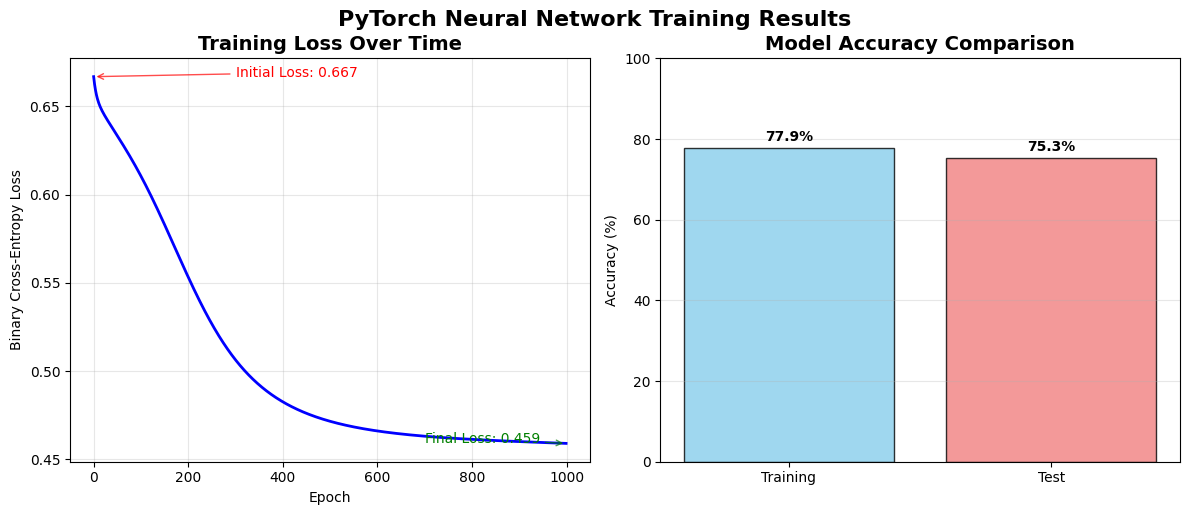

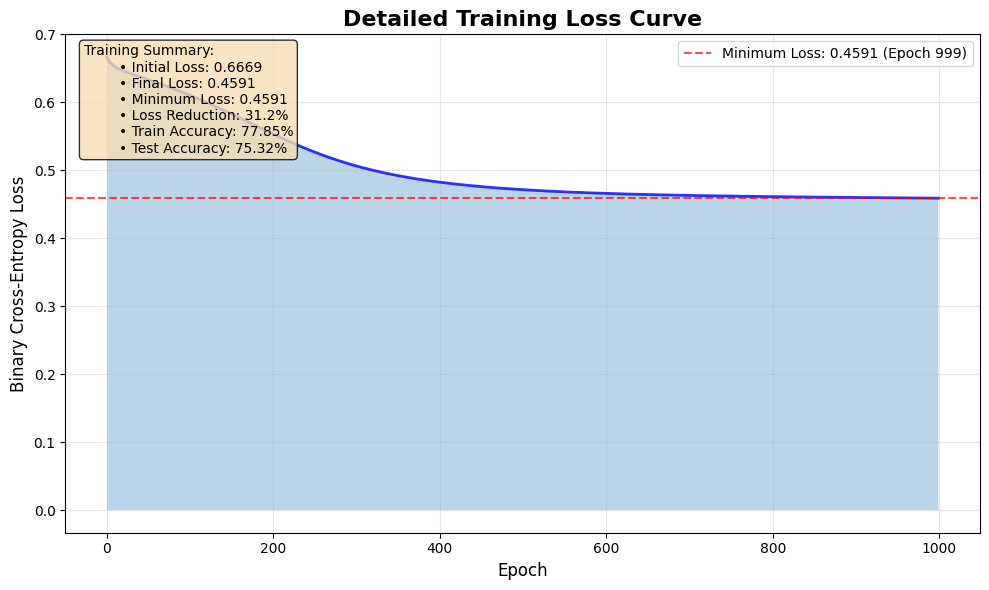


=== Training Statistics ===
Initial Loss: 0.6669
Final Loss: 0.4591
Minimum Loss: 0.4591 (at epoch 999)
Loss Reduction: 31.2%
Average Loss (first 100 epochs): 0.6342
Average Loss (last 100 epochs): 0.4596
Training appears to have converged


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_training_results():
    """
    Plot the training results from the saved file
    """
    try:
        # Load the saved training results
        results = torch.load('training_results.pth')
        costs = results['costs']
        train_accuracy = results['train_accuracy']
        test_accuracy = results['test_accuracy']

        print("=== Loaded Training Results ===")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Test Accuracy: {test_accuracy:.2f}%")
        print(f"Total Epochs: {len(costs)}")

        # Create the plot
        plt.figure(figsize=(12, 5))

        # Plot 1: Training Loss/Cost
        plt.subplot(1, 2, 1)
        plt.plot(costs, 'b-', linewidth=2)
        plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Binary Cross-Entropy Loss')
        plt.grid(True, alpha=0.3)

        # Add annotations for key points
        plt.annotate(f'Initial Loss: {costs[0]:.3f}',
                    xy=(0, costs[0]), xytext=(len(costs)*0.3, costs[0]),
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                    fontsize=10, color='red')

        plt.annotate(f'Final Loss: {costs[-1]:.3f}',
                    xy=(len(costs)-1, costs[-1]), xytext=(len(costs)*0.7, costs[-1]),
                    arrowprops=dict(arrowstyle='->', color='green', alpha=0.7),
                    fontsize=10, color='green')

        # Plot 2: Accuracy Comparison
        plt.subplot(1, 2, 2)
        accuracies = [train_accuracy, test_accuracy]
        labels = ['Training', 'Test']
        colors = ['skyblue', 'lightcoral']

        bars = plt.bar(labels, accuracies, color=colors, alpha=0.8, edgecolor='black')
        plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Accuracy (%)')
        plt.ylim(0, 100)

        # Add value labels on bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{accuracy:.1f}%', ha='center', va='bottom', fontweight='bold')

        plt.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.suptitle('PyTorch Neural Network Training Results', fontsize=16, fontweight='bold', y=1.02)
        plt.show()

        # Additional detailed plot of loss
        plt.figure(figsize=(10, 6))
        plt.plot(costs, 'b-', linewidth=2, alpha=0.8)
        plt.fill_between(range(len(costs)), costs, alpha=0.3)
        plt.title('Detailed Training Loss Curve', fontsize=16, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Binary Cross-Entropy Loss', fontsize=12)
        plt.grid(True, alpha=0.3)

        # Add statistics
        min_loss = min(costs)
        min_epoch = costs.index(min_loss)

        plt.axhline(y=min_loss, color='red', linestyle='--', alpha=0.7,
                   label=f'Minimum Loss: {min_loss:.4f} (Epoch {min_epoch})')
        plt.legend()

        # Add text box with training info
        info_text = f"""Training Summary:
        • Initial Loss: {costs[0]:.4f}
        • Final Loss: {costs[-1]:.4f}
        • Minimum Loss: {min_loss:.4f}
        • Loss Reduction: {((costs[0] - costs[-1])/costs[0]*100):.1f}%
        • Train Accuracy: {train_accuracy:.2f}%
        • Test Accuracy: {test_accuracy:.2f}%"""

        plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Print some statistics
        print(f"\n=== Training Statistics ===")
        print(f"Initial Loss: {costs[0]:.4f}")
        print(f"Final Loss: {costs[-1]:.4f}")
        print(f"Minimum Loss: {min_loss:.4f} (at epoch {min_epoch})")
        print(f"Loss Reduction: {((costs[0] - costs[-1])/costs[0]*100):.1f}%")

        # Check for convergence
        last_100_avg = np.mean(costs[-100:]) if len(costs) >= 100 else np.mean(costs[-len(costs)//2:])
        first_100_avg = np.mean(costs[:100]) if len(costs) >= 100 else np.mean(costs[:len(costs)//2])

        print(f"Average Loss (first 100 epochs): {first_100_avg:.4f}")
        print(f"Average Loss (last 100 epochs): {last_100_avg:.4f}")
        print(f"Training appears to have {'converged' if abs(costs[-1] - costs[-50]) < 0.001 else 'not fully converged'}")

    except FileNotFoundError:
        print("Error: training_results.pth not found!")
        print("Please run the neural network training script first.")
    except Exception as e:
        print(f"Error loading results: {e}")

if __name__ == "__main__":
    print("=== Neural Network Training Results Plotter ===\n")
    plot_training_results()